C:\Users\Kenneth\AppData\Local\Temp\ipykernel_10976\1771119392.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 1])


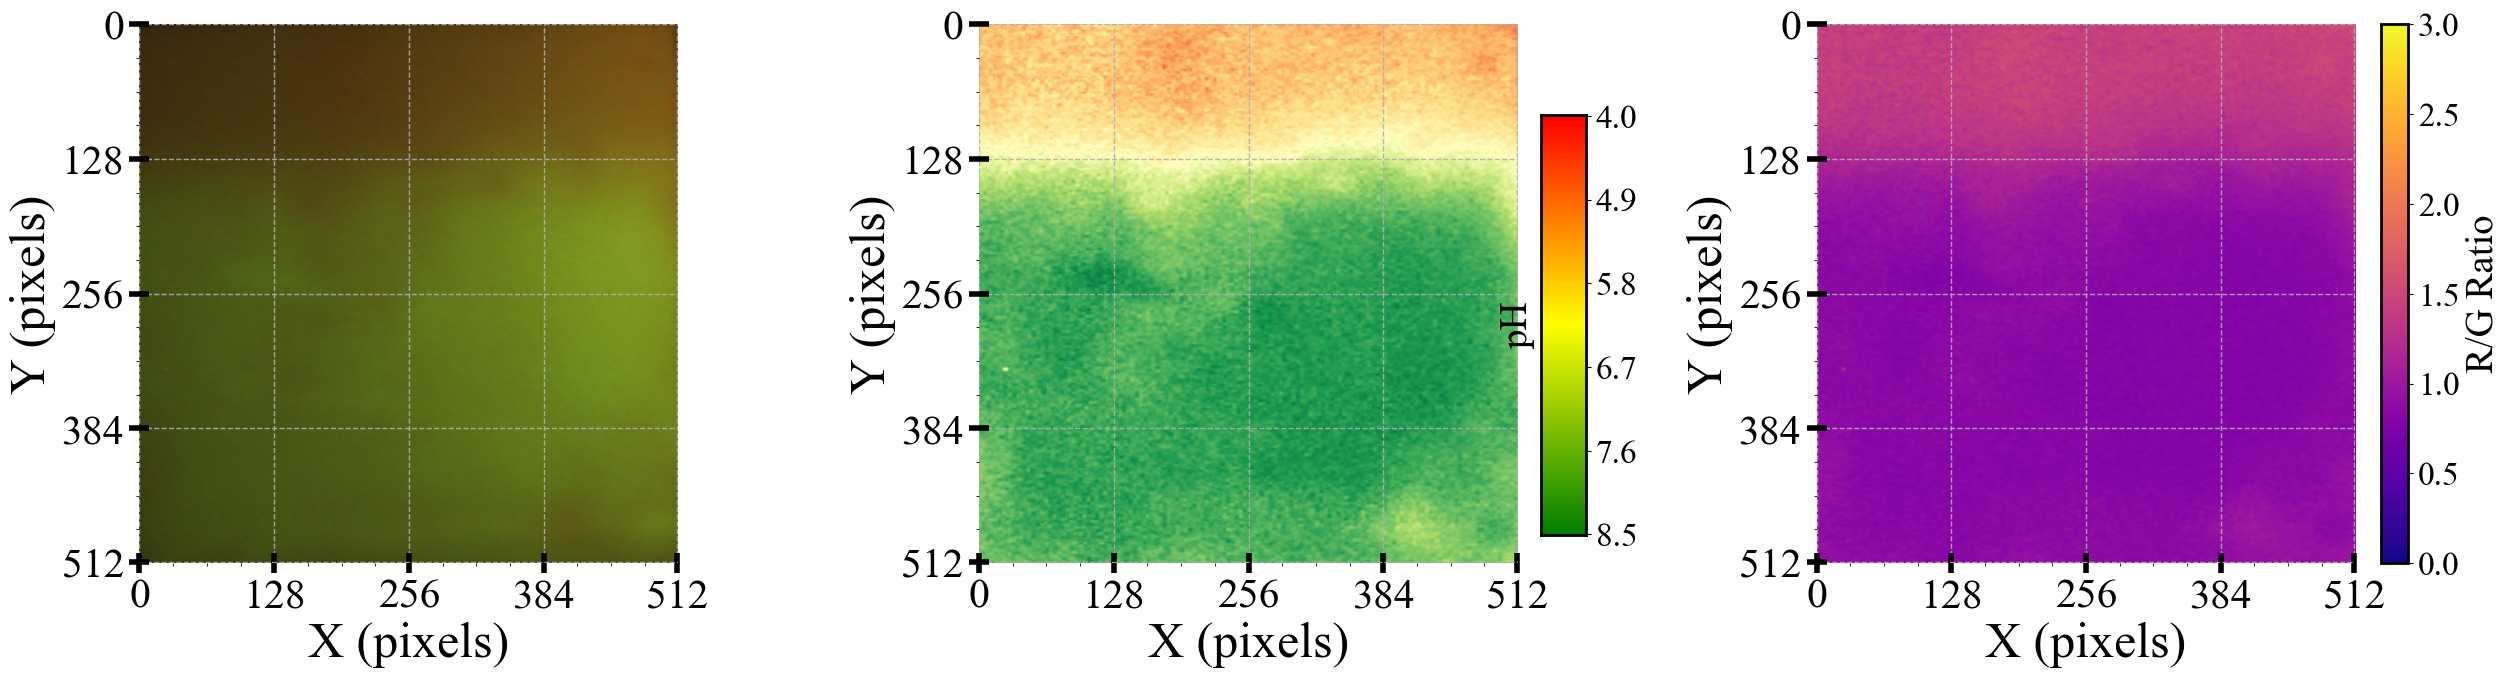

In [10]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from skimage import io
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

# --- Global Styles ---
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 28
mpl.rcParams['axes.linewidth'] = 2

# --- Calibration constants ---
A1 = 3.0766531
A2 = 0.40657041
X0 = 6.0663465
dx = 0.83143555

def ratio_to_pH(ratio):
    """Convert R/G ratio to estimated pH using calibration curve."""
    ratio = np.clip(ratio, A2 + 1e-5, A1 - 1e-5)
    return X0 - dx * np.log10((A1 - A2) / (ratio - A2) - 1)

# --- Load image ---
image_path = r'C:\Optode_Images_Raw\SN_ST_R0PH_00007.png'
image = io.imread(image_path)

if image.ndim == 2:
    image = np.stack([image]*3, axis=-1)
elif image.shape[2] == 4:
    image = image[:, :, :3]

target_size = (512, 512)
image_resized = cv.resize(image, target_size, interpolation=cv.INTER_LINEAR)

# Extract channels
R = image_resized[:, :, 0].astype(np.float32)
G = image_resized[:, :, 1].astype(np.float32)

# Compute R/G ratio and pH map
epsilon = 1e-6
rg_ratio = R / (G + epsilon)
pH_map = ratio_to_pH(rg_ratio)
pH_map = np.clip(pH_map, 4.0, 8.5)

# Prepare pixel tick positions
tick_labels = ['0', '128', '256', '384', '512']
tick_pos = [0, 128, 256, 384, 511]

# --- Helper: Format map axes ---
def format_map_axes(ax, label=False):
    ax.set_xticks(tick_pos)
    ax.set_yticks(tick_pos)
    ax.set_xticklabels(tick_labels, fontsize=30)
    ax.set_yticklabels(tick_labels, fontsize=30)
    ax.set_xlim(0, 512)
    ax.set_ylim(512, 0)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', direction='inout', width=4, length=15)
    ax.grid(True, which='major', linestyle='--', linewidth=1, alpha=0.9)
    for spine in ax.spines.values():
        spine.set_visible(False)
    if label:
        ax.set_xlabel('X (pixels)', fontsize=36)
        ax.set_ylabel('Y (pixels)', fontsize=36)

# --- Plot ---
fig, axs = plt.subplots(1, 3, figsize=(30, 7), gridspec_kw={'wspace': 0.3})

# --- Map 1 (RGB Image) ---
axs[0].imshow(image_resized)
format_map_axes(axs[0], label=True)


div_cmap = plt.get_cmap('RdYlGn_r')
norm = TwoSlopeNorm(vmin=0.7, vcenter=1.2, vmax=1.9)
im_rg = axs[1].imshow(rg_ratio, cmap=div_cmap, norm=norm)
format_map_axes(axs[1], label=True)

# --- pH Colorbar Legend ---
gradient = np.linspace(0, 1, 256).reshape(-1, 1)
gradient_image = np.repeat(gradient, 10, axis=1)
ph_cmap = LinearSegmentedColormap.from_list("pH_custom", ["green", "yellow", "red"])
cax = fig.add_axes([0.61, 0.15, 0.015, 0.6])
cax.imshow(gradient_image, aspect='auto', cmap=ph_cmap, origin='lower')
cax.set_yticks(np.linspace(0, 255, 6))
cax.set_yticklabels(np.linspace(4.0, 8.5, 6)[::-1])
cax.tick_params(axis='y', labelsize=24)
cax.set_xticks([])
cax.set_ylabel("pH", fontsize=28)
cax.yaxis.set_ticks_position('right')
cax.yaxis.label.set_position((1.3, 0.5))

# --- Map 3 (Plasma Color R/G Ratio Map) ---
im_ph = axs[2].imshow(rg_ratio, cmap='plasma', vmin=0, vmax=3)
format_map_axes(axs[2], label=True)
cbar_ph = plt.colorbar(im_ph, ax=axs[2], fraction=0.046, pad=0.04)
cbar_ph.ax.tick_params(labelsize=24)
cbar_ph.set_label("R/G Ratio", fontsize=28)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()
